# 3d. Evaluate bed demand predictions by hospital service

In the previous notebook, I showed how to train a model to predict which hospital service a patient will be admitted to, and combined this with an admission probability model to generate bed count predictions by hospital service for a single group snapshot.

In this notebook, I evaluate those predictions across the full test set, using the evaluation approaches introduced in notebook 3b:

* Histograms of observed versus expected values
* EPUDD (Evaluating Predictions for Unique Discrete Distributions) plots

In the appendix, I compare the service prediction model with a baseline that uses average admission proportions by hospital service.

### About the data used in this notebook

You can request the UCLH datasets on [Zenodo](https://zenodo.org/records/14866057). If you don't have the public data, change `data_folder_name` from `'data-public'` to `'data-synthetic'`.

In [1]:
# Reload functions every time
%load_ext autoreload
%autoreload 2

## Load data and train models

The data loading, model configuration, and model training steps were demonstrated in detail in previous notebook 3b (for admission models trained at each prediction time) and notebook 3c for the hospital service prediction model. Here I use `prepare_prediction_inputs`, a convenience function that performs all of these steps in a single call. It trains admission models for each prediction time, a hospital service prediction model, and a yet-to-arrive model.

In [2]:
from patientflow.train.emergency_demand import prepare_prediction_inputs

data_folder_name = 'data-public'
prediction_inputs = prepare_prediction_inputs(data_folder_name)

# Unpack the results
admissions_models = prediction_inputs['admission_models']
spec_model = prediction_inputs['specialty_model']
ed_visits = prediction_inputs['ed_visits']
inpatient_arrivals = prediction_inputs['inpatient_arrivals']
specialties = prediction_inputs['specialties']
params = prediction_inputs['config']

Split sizes: [62071, 10415, 29134]
Split sizes: [7716, 1285, 3898]

Processing: (6, 0)



Processing: (9, 30)



Processing: (12, 0)



Processing: (15, 30)



Processing: (22, 0)


Below I use the training, validation and test set dates set in `config.yaml` to retrieve the portion of the data that forms the test set.

In [3]:
import pandas as pd
from patientflow.prepare import create_temporal_splits
from patientflow.load import get_model_key

model_name = 'admissions'

# Extract config parameters
start_training_set = params['start_training_set']
start_validation_set = params['start_validation_set']
start_test_set = params['start_test_set']
end_test_set = params['end_test_set']

# Create temporal splits for the ED visits
_, _, test_visits_df = create_temporal_splits(
    ed_visits, start_training_set, start_validation_set,
    start_test_set, end_test_set, col_name='snapshot_date',
)

Split sizes: [62071, 10415, 29134]


## Generate predicted distributions by hospital service

In notebook 3c, I demonstrated how to generate a predicted bed count distribution for one hospital service and one group snapshot. To evaluate the model, I need to generate predictions for every group snapshot in the test set, for each hospital service and prediction time.

The function below does this by:

1. Predicting each patient's probability of admission to each hospital service (using the service prediction model)
2. For each prediction time and each hospital service, weighting the admission probabilities by the service probabilities to generate a service-specific bed count distribution
3. Recording the observed number of admissions to each service for comparison

The `category_filter` parameter passed to `get_prob_dist` ensures that the observed counts reflect only patients admitted to the specific hospital service being evaluated, while the `weights` parameter adjusts the predicted distribution to reflect the probability of admission to that service.

In [4]:
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict
from patientflow.aggregate import get_prob_dist
from patientflow.load import get_model_key


def get_specialty_probability_distributions(
    test_visits_df,
    spec_model,
    admissions_models,
    model_name,
    specialties=['medical', 'surgical', 'haem/onc', 'paediatric'],
    baseline_prob_dict=None,
):
    """
    Calculate probability distributions for ED patients by hospital service and prediction time.
    
    Args:
        test_visits_df: DataFrame containing test visit data
        spec_model: Model for hospital service predictions
        admissions_models: Dictionary of admission prediction models
        model_name: Name of the model to use
        specialties: List of hospital services to consider
        baseline_prob_dict: Optional dict of baseline probabilities to use instead of model predictions
        
    Returns:
        Dictionary containing probability distributions for each service and prediction time
    """

    if baseline_prob_dict is not None:
        test_visits_df.loc[:, "specialty_prob"] = test_visits_df.apply(
            lambda row: baseline_prob_dict,
            axis=1
        )
    else:
        if hasattr(spec_model, "predict_dataframe"):
            test_visits_df.loc[:, "specialty_prob"] = spec_model.predict_dataframe(test_visits_df)
        else:
            def determine_specialty(row):
                return spec_model.predict(row["consultation_sequence"])
            
            test_visits_df.loc[:, "specialty_prob"] = test_visits_df.apply(determine_specialty, axis=1)

    prob_dist_dict_all = {}

    for _prediction_time in test_visits_df.prediction_time.unique():
        prob_dist_dict_for_pats_in_ED = {}
        print("\nProcessing :" + str(_prediction_time))
        model_key = get_model_key(model_name, _prediction_time)
        
        for specialty in specialties:
            print(f"Predicting bed counts for {specialty} service, for all snapshots in the test set")

            prob_admission_to_specialty = test_visits_df["specialty_prob"].apply(
                lambda x: x.get(specialty, 0.0) if isinstance(x, dict) else 0.0
            )
            
            X_test, y_test = prepare_patient_snapshots(
                df=test_visits_df, 
                prediction_time=_prediction_time, 
                single_snapshot_per_visit=False,
                visit_col='visit_number'
            )

            group_snapshots_dict = prepare_group_snapshot_dict(
                test_visits_df[test_visits_df.prediction_time == _prediction_time]
            )

            admitted_to_specialty = test_visits_df['specialty'] == specialty

            prob_dist_dict_for_pats_in_ED[specialty] = get_prob_dist(
                group_snapshots_dict, X_test, y_test, admissions_models[model_key], 
                weights=prob_admission_to_specialty,
                category_filter=admitted_to_specialty, 
                normal_approx_threshold=30
            )

        prob_dist_dict_all[f'{model_key}'] = prob_dist_dict_for_pats_in_ED

    return prob_dist_dict_all

In [5]:
prob_dist_dict_all = get_specialty_probability_distributions(
    test_visits_df,
    spec_model,
    admissions_models,
    model_name)


Processing :(22, 0)
Predicting bed counts for medical service, for all snapshots in the test set


Predicting bed counts for surgical service, for all snapshots in the test set


Predicting bed counts for haem/onc service, for all snapshots in the test set


Predicting bed counts for paediatric service, for all snapshots in the test set



Processing :(6, 0)
Predicting bed counts for medical service, for all snapshots in the test set


Predicting bed counts for surgical service, for all snapshots in the test set


Predicting bed counts for haem/onc service, for all snapshots in the test set


Predicting bed counts for paediatric service, for all snapshots in the test set



Processing :(15, 30)
Predicting bed counts for medical service, for all snapshots in the test set


Predicting bed counts for surgical service, for all snapshots in the test set


Predicting bed counts for haem/onc service, for all snapshots in the test set


Predicting bed counts for paediatric service, for all snapshots in the test set



Processing :(9, 30)
Predicting bed counts for medical service, for all snapshots in the test set


Predicting bed counts for surgical service, for all snapshots in the test set


Predicting bed counts for haem/onc service, for all snapshots in the test set


Predicting bed counts for paediatric service, for all snapshots in the test set



Processing :(12, 0)
Predicting bed counts for medical service, for all snapshots in the test set


Predicting bed counts for surgical service, for all snapshots in the test set


Predicting bed counts for haem/onc service, for all snapshots in the test set


Predicting bed counts for paediatric service, for all snapshots in the test set


## Evaluate predictions by hospital service

I now evaluate the predicted distributions using the approaches introduced in notebook 3b. First, histograms showing the difference between observed and expected values for each hospital service. Then, EPUDD plots which evaluate the full predicted distribution against observed values.

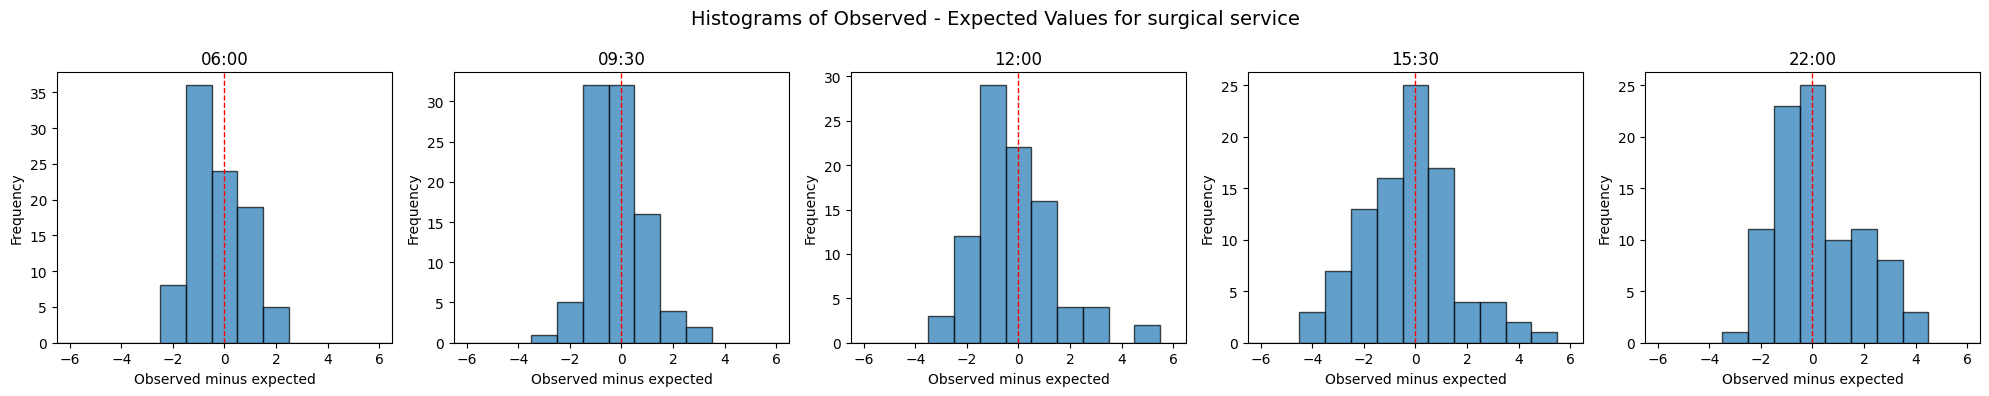

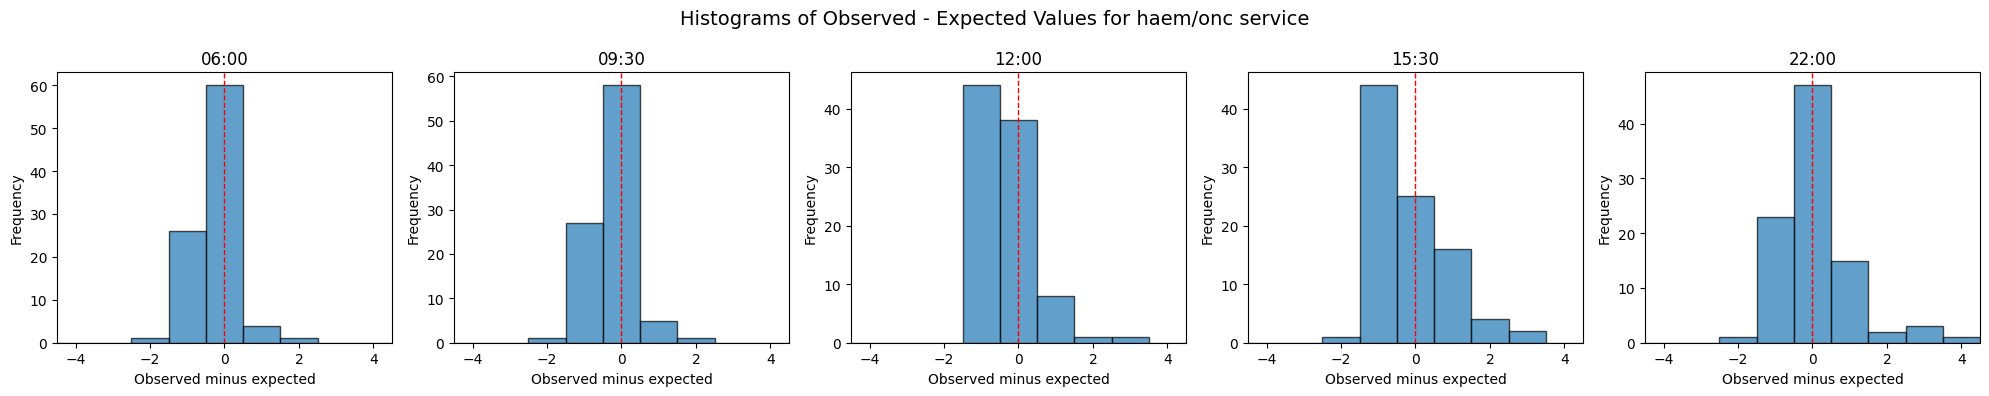

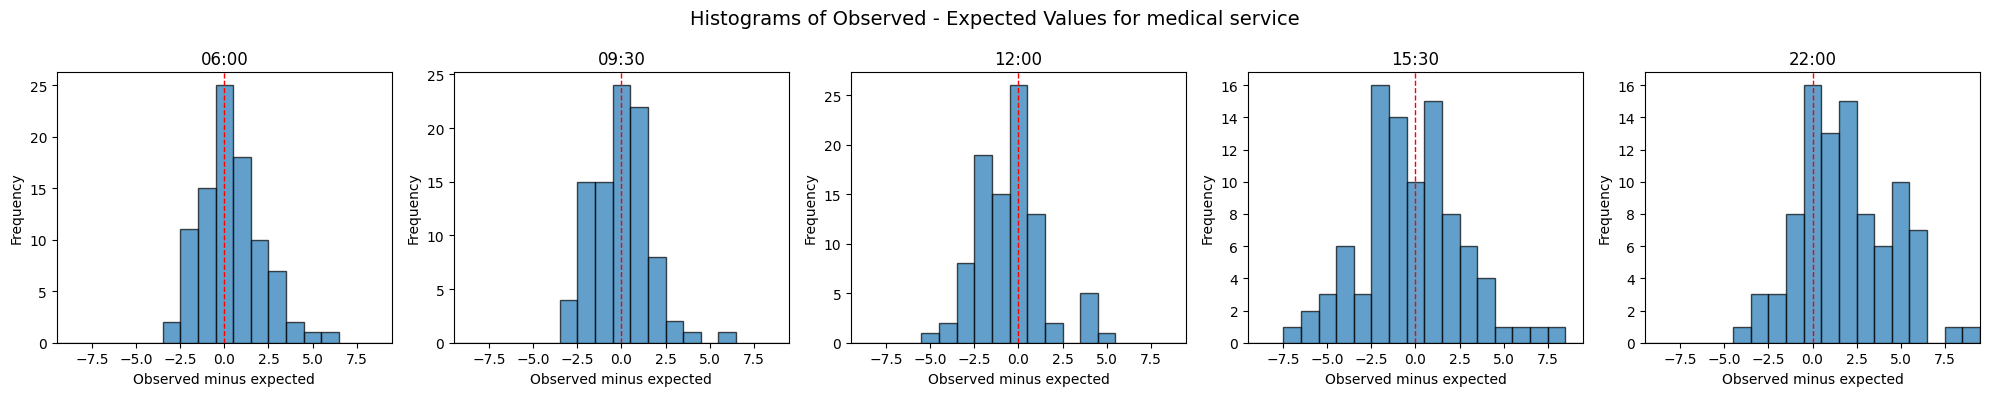

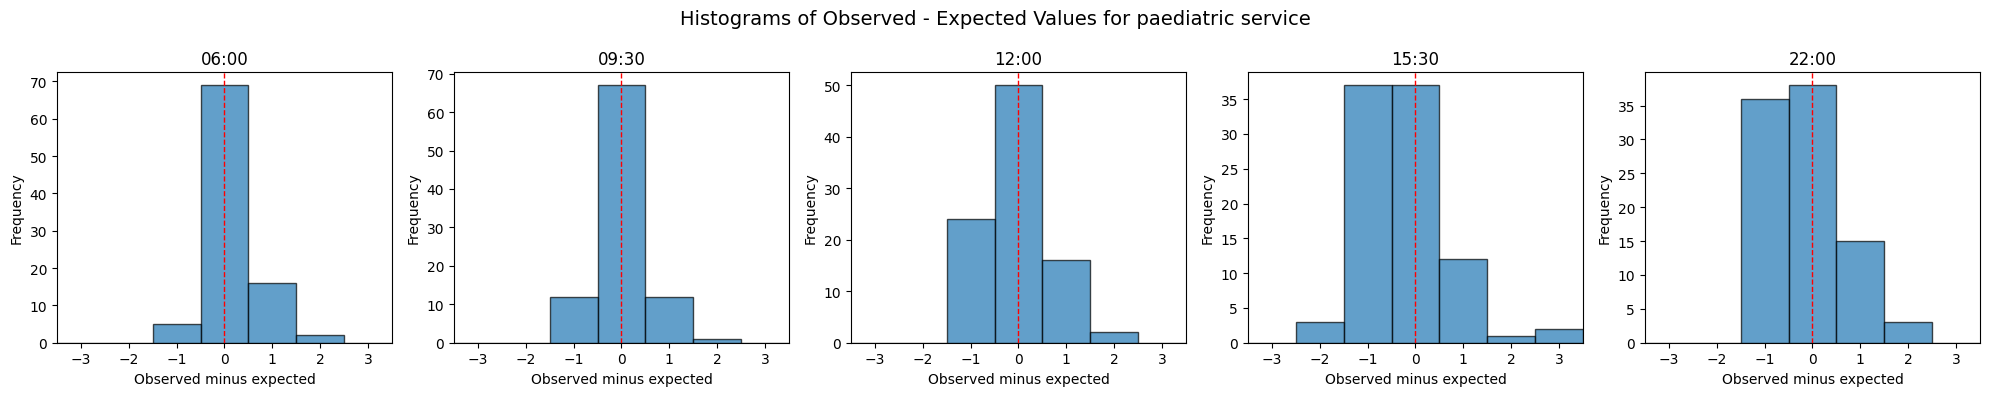

In [6]:
from patientflow.evaluate import calc_mae_mpe
from patientflow.viz.observed_against_expected import plot_deltas

for specialty in specialties:
    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}
    results = calc_mae_mpe(specialty_prob_dist)
    plot_deltas(results, suptitle=f"Histograms of Observed - Expected Values for {specialty} service")

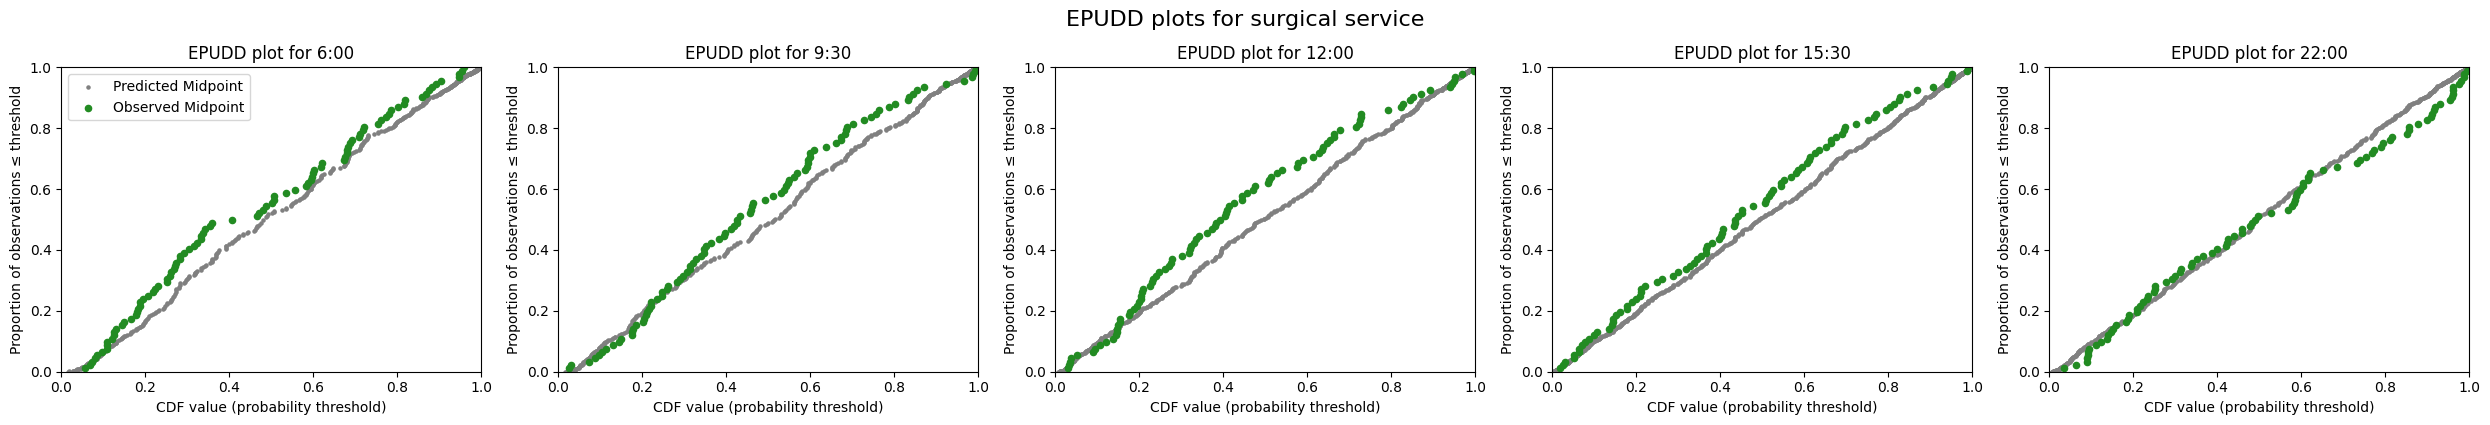

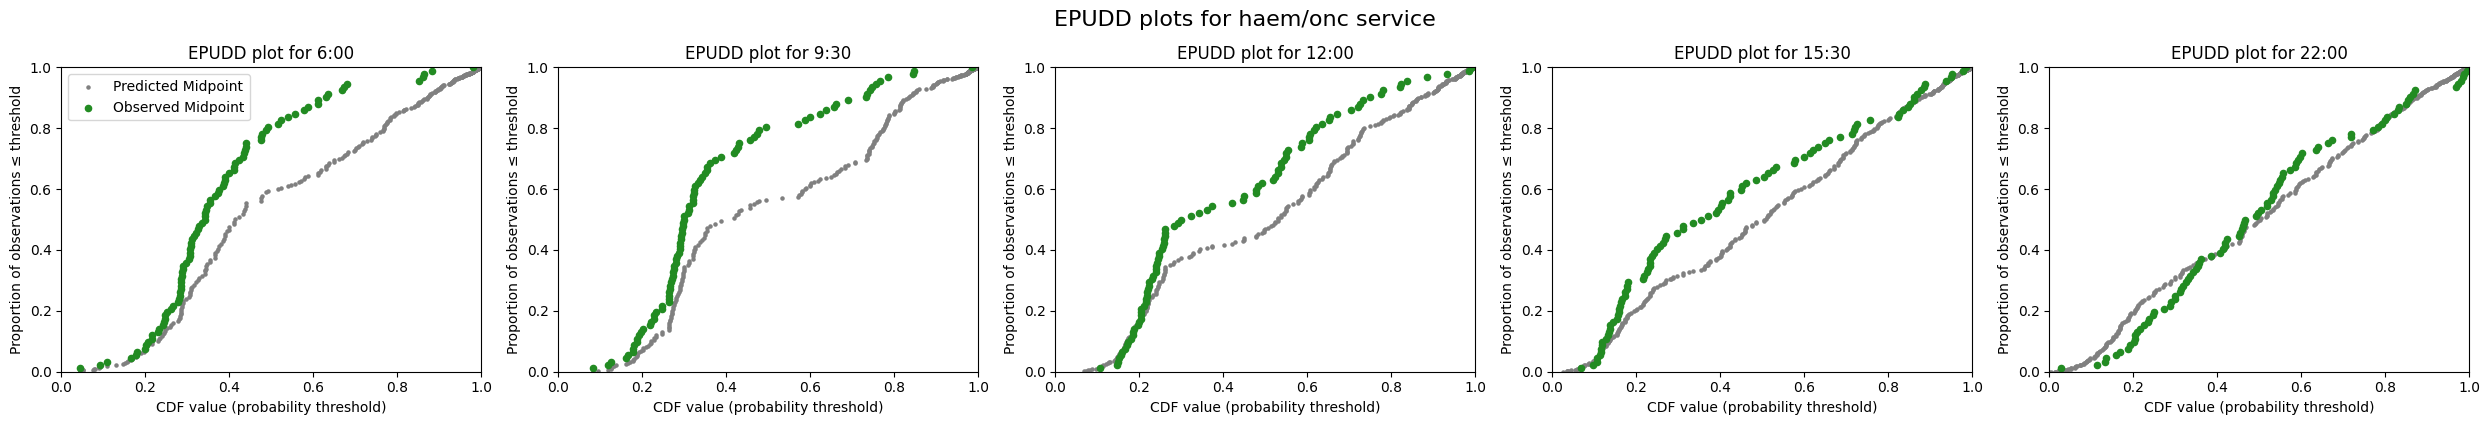

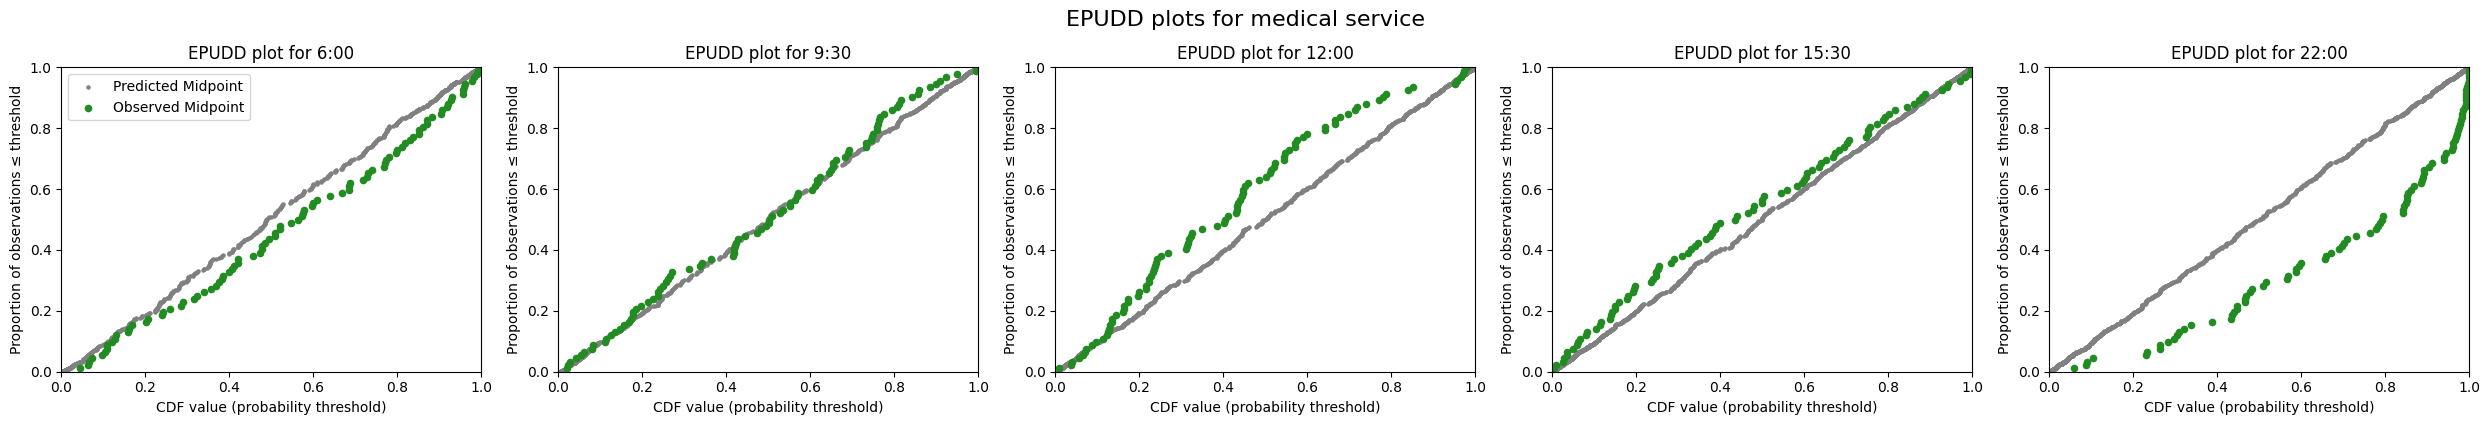

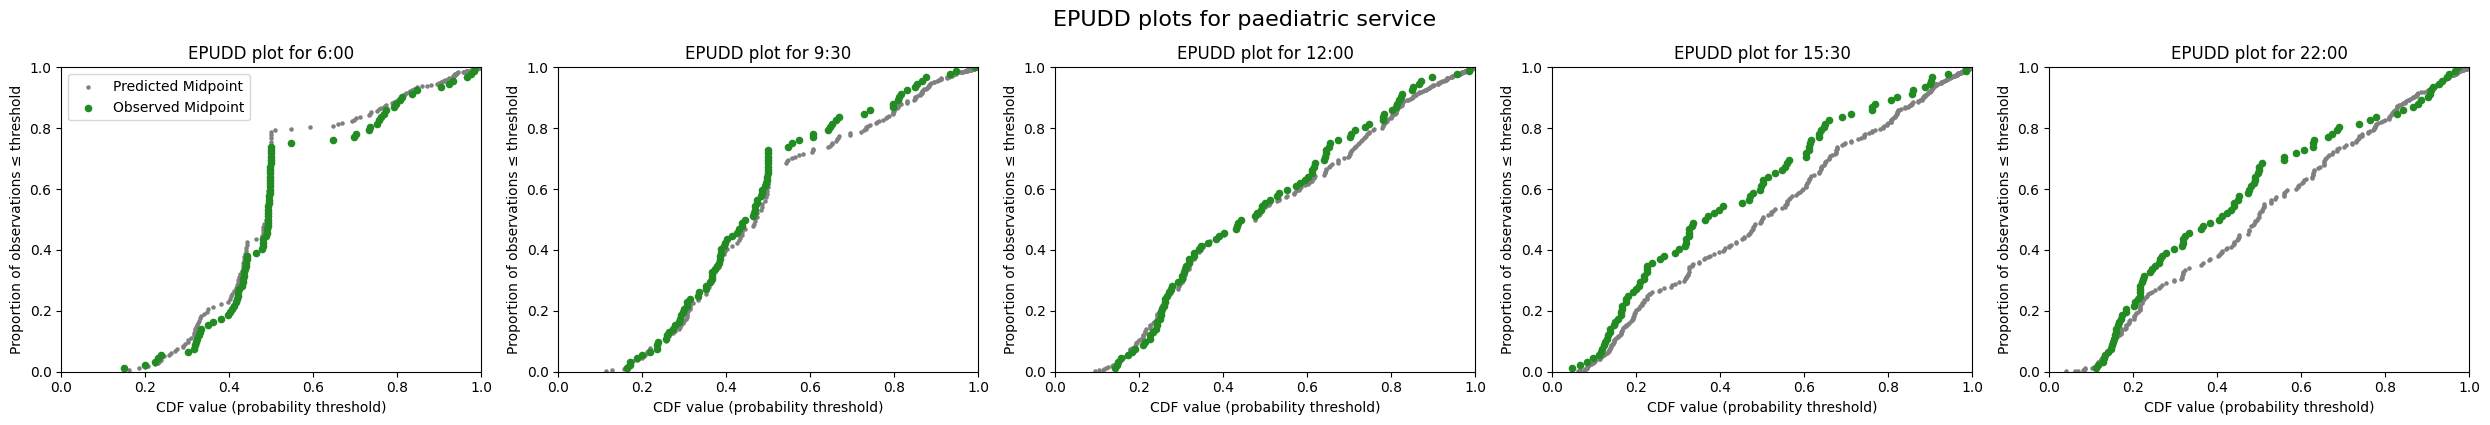

In [7]:
from patientflow.viz.epudd import plot_epudd

for specialty in specialties:
    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}

    plot_epudd(ed_visits.prediction_time.unique(), 
            specialty_prob_dist,
            model_name="admissions",
            suptitle=f"EPUDD plots for {specialty} service")

## Summary

In this notebook I have shown how to evaluate predicted bed count distributions by hospital service, using the evaluation approaches introduced in notebook 3b. In the appendix below, I compare the service prediction model against a baseline that uses average admission proportions by hospital service.

In the notebooks that follow, prefixed with 4, I demonstrate how these functions are assembled into a production system at University College London Hospital to predict emergency demand.

## Appendix: Comparing with a baseline prediction by hospital service

The service prediction model used above was trained on sequences of consults. A natural baseline is to give each patient the same probability of admission to each hospital service, based on past averages. To calculate past averages, I use the `inpatient_arrivals` dataset, which includes all arrivals with one row per visit.

In [8]:

# Create temporal splits for inpatient arrivals (used in appendix for baseline comparison)
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(
    inpatient_arrivals['arrival_datetime'], utc=True
)
train_inpatient_arrivals_df, _, _ = create_temporal_splits(
    inpatient_arrivals, start_training_set, start_validation_set,
    start_test_set, end_test_set, col_name='arrival_datetime',
)

baseline_probs = train_inpatient_arrivals_df['specialty'].value_counts(normalize=True).to_dict()

prob_dist_dict_all_baseline = get_specialty_probability_distributions(
    test_visits_df=test_visits_df,
    spec_model=spec_model,      
    admissions_models=admissions_models,
    model_name=model_name,
    baseline_prob_dict=baseline_probs
)

Split sizes: [7716, 1285, 3898]

Processing :(22, 0)
Predicting bed counts for medical service, for all snapshots in the test set


Predicting bed counts for surgical service, for all snapshots in the test set


Predicting bed counts for haem/onc service, for all snapshots in the test set


Predicting bed counts for paediatric service, for all snapshots in the test set



Processing :(6, 0)
Predicting bed counts for medical service, for all snapshots in the test set


Predicting bed counts for surgical service, for all snapshots in the test set


Predicting bed counts for haem/onc service, for all snapshots in the test set


Predicting bed counts for paediatric service, for all snapshots in the test set



Processing :(15, 30)
Predicting bed counts for medical service, for all snapshots in the test set


Predicting bed counts for surgical service, for all snapshots in the test set


Predicting bed counts for haem/onc service, for all snapshots in the test set


Predicting bed counts for paediatric service, for all snapshots in the test set



Processing :(9, 30)
Predicting bed counts for medical service, for all snapshots in the test set


Predicting bed counts for surgical service, for all snapshots in the test set


Predicting bed counts for haem/onc service, for all snapshots in the test set


Predicting bed counts for paediatric service, for all snapshots in the test set



Processing :(12, 0)
Predicting bed counts for medical service, for all snapshots in the test set


Predicting bed counts for surgical service, for all snapshots in the test set


Predicting bed counts for haem/onc service, for all snapshots in the test set


Predicting bed counts for paediatric service, for all snapshots in the test set


The EPUDD plots below show two plots per hospital service: the baseline model using average proportions admitted to each service (upper), and the model where service of admission is predicted using consult sequences (lower). Particularly for services with small admission numbers (haem/onc and paediatric) there is an improvement; the extent of over-prediction is reduced.


EPUDD plots for surgical service: baseline vs sequence predictor


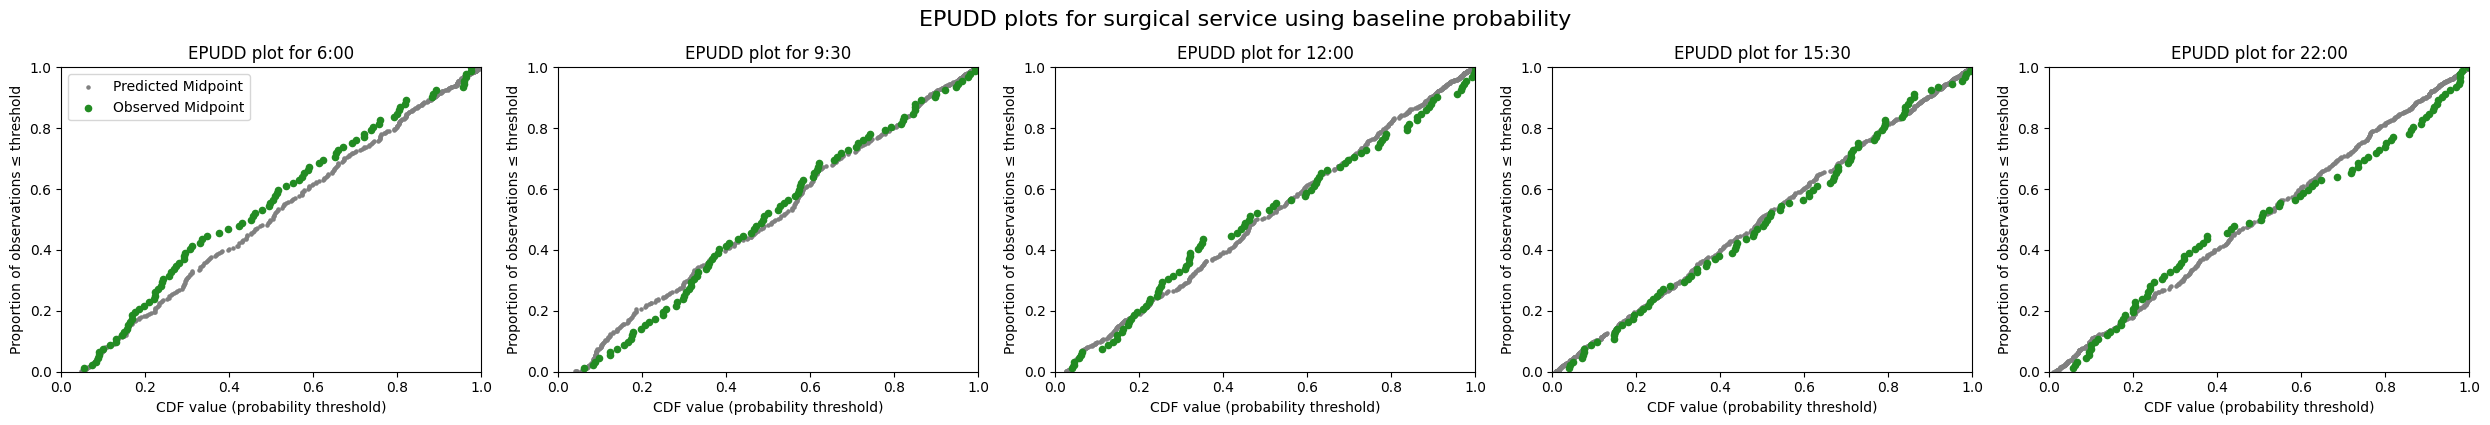

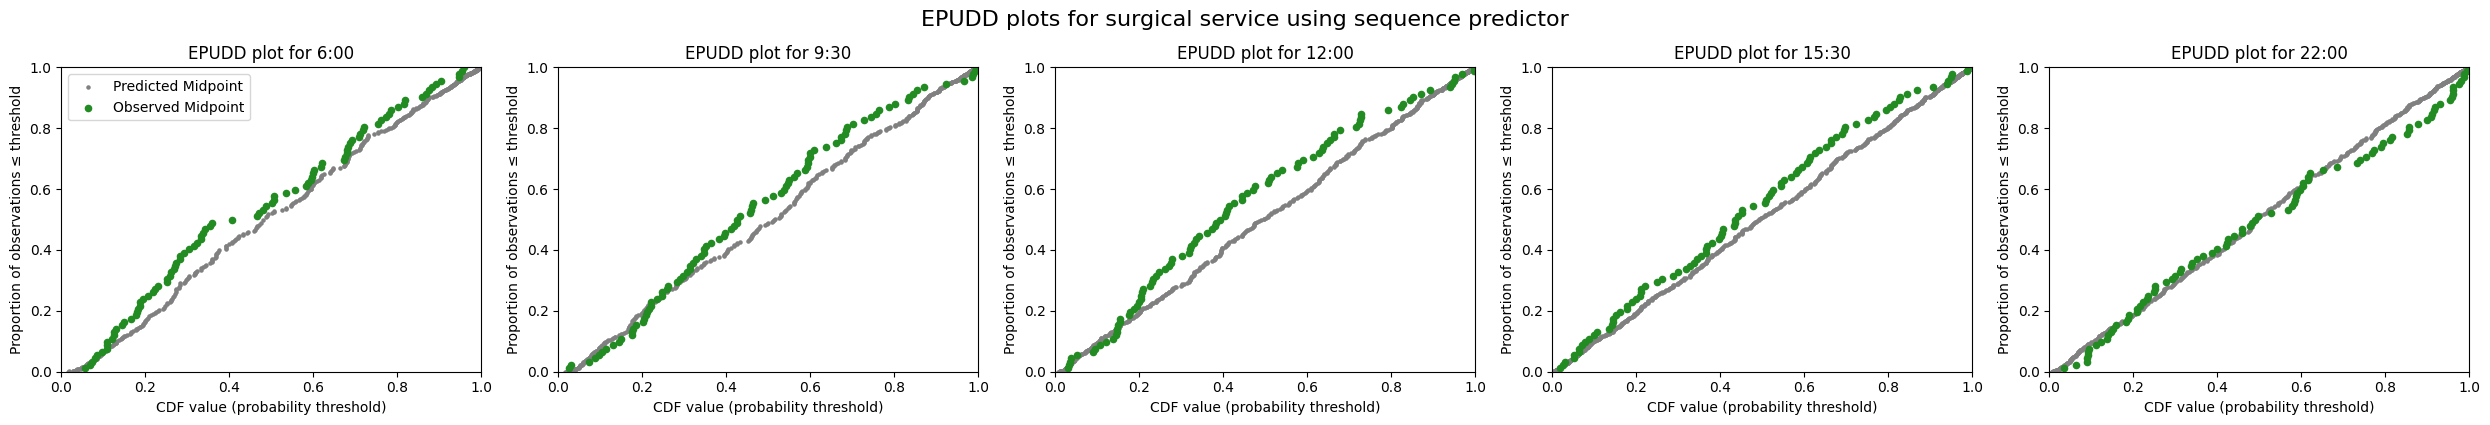


EPUDD plots for haem/onc service: baseline vs sequence predictor


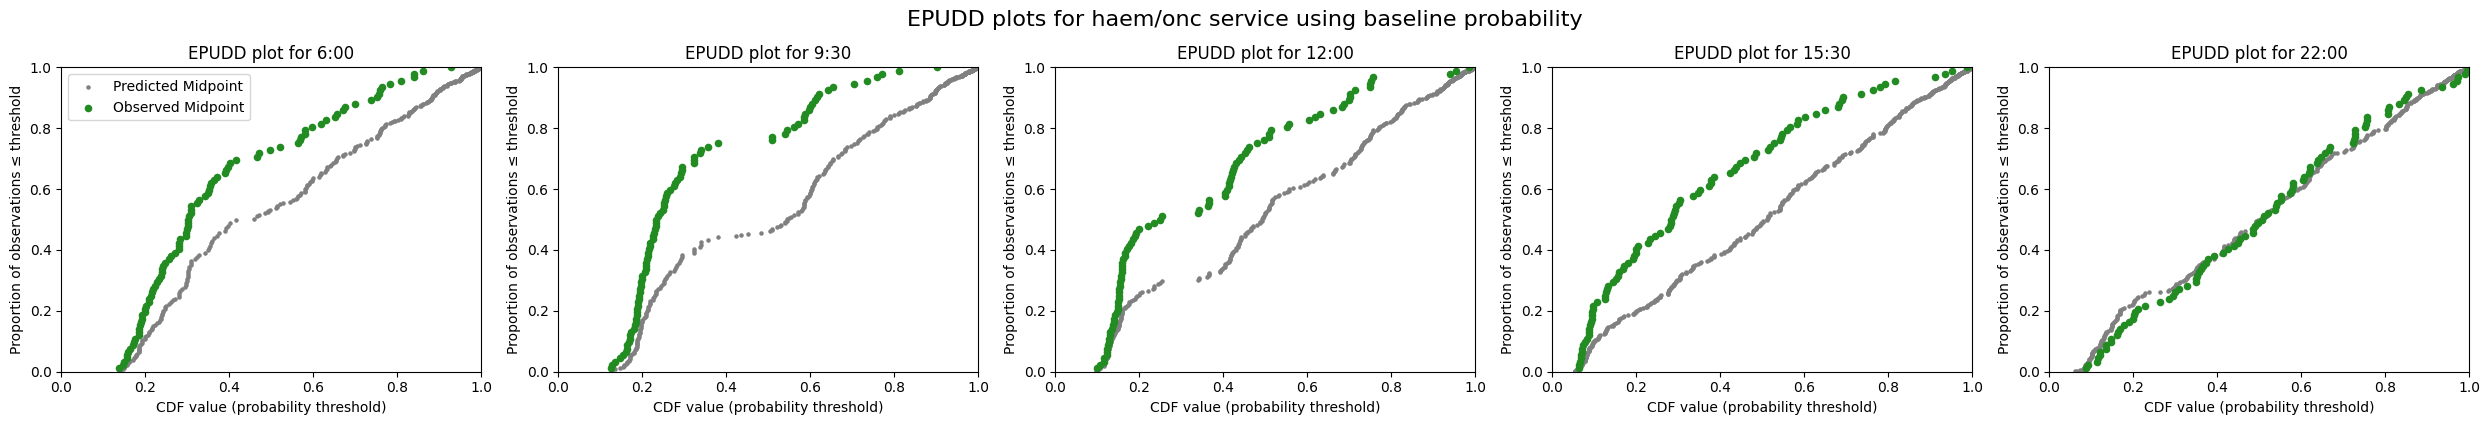

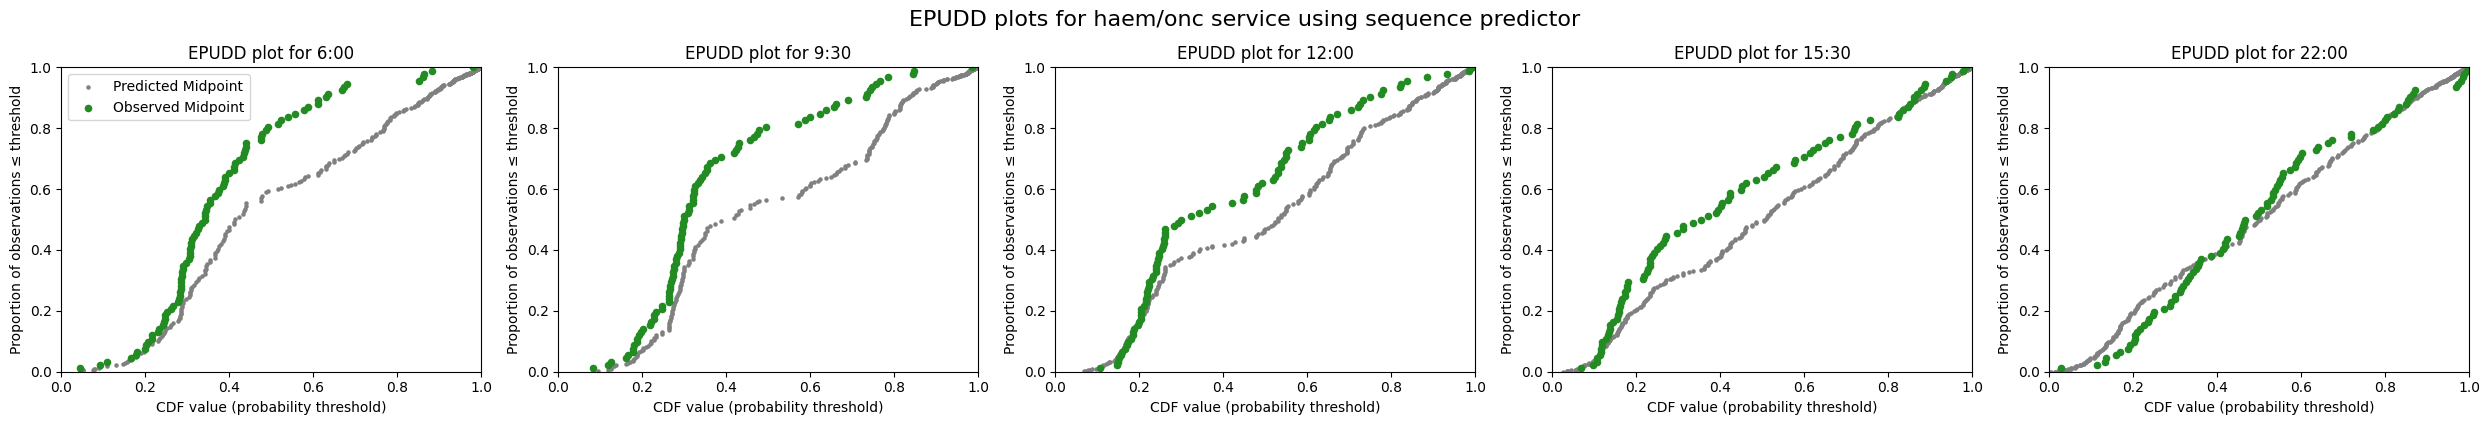


EPUDD plots for medical service: baseline vs sequence predictor


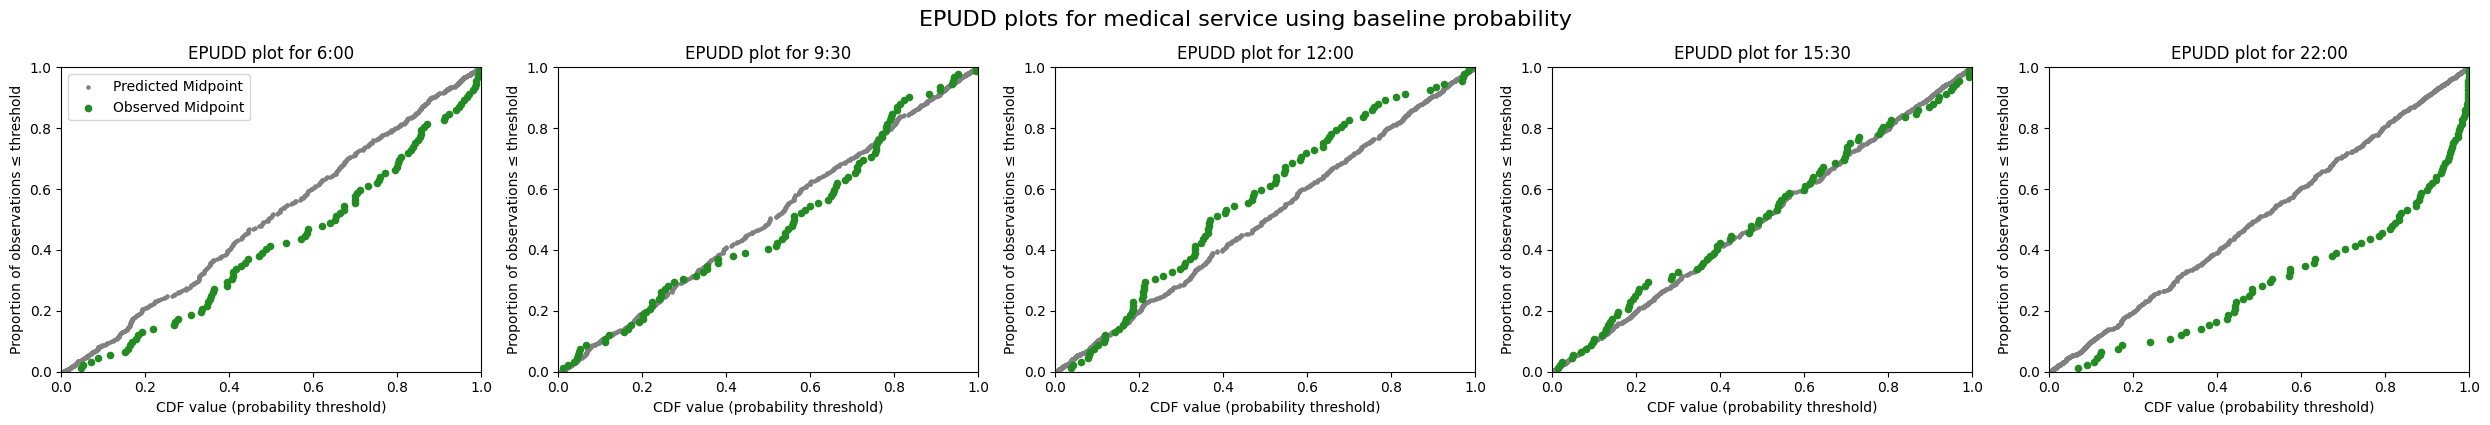

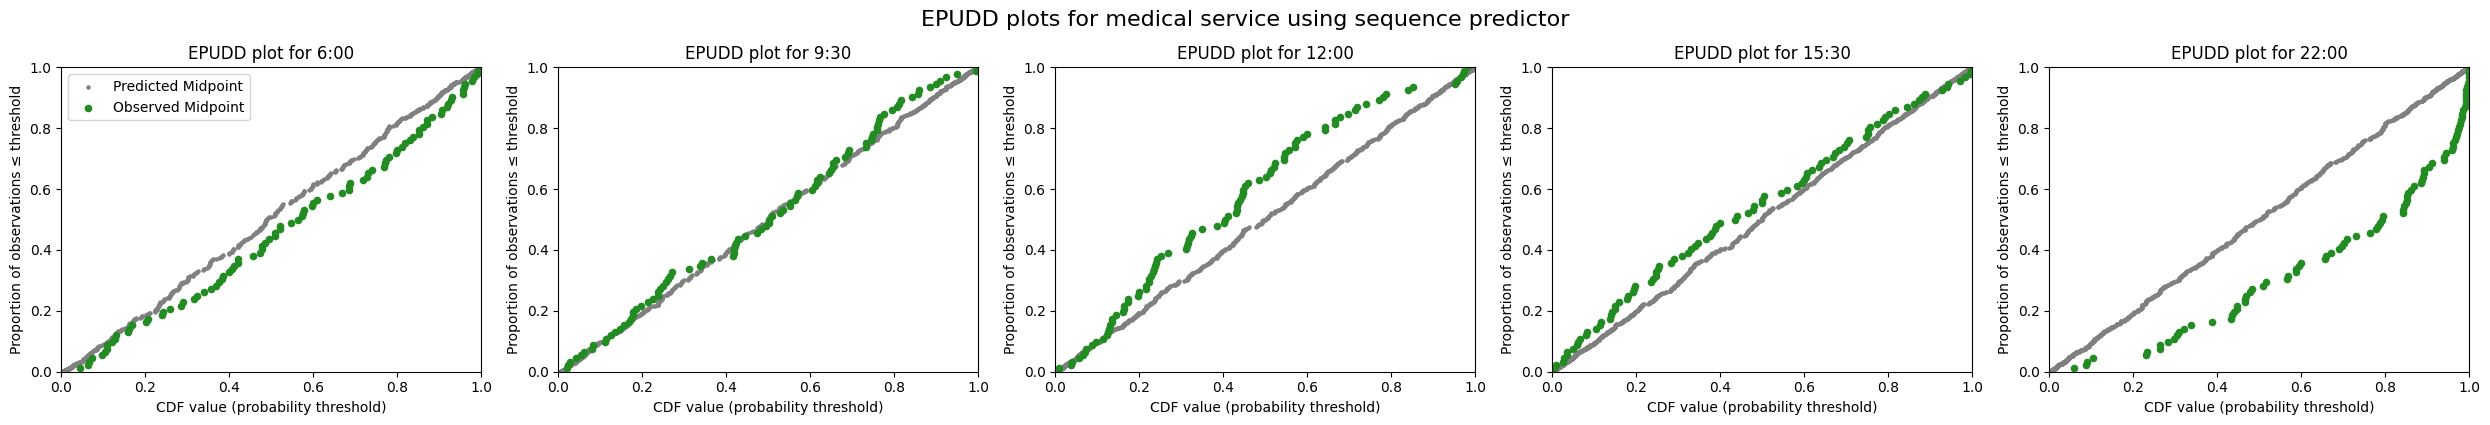


EPUDD plots for paediatric service: baseline vs sequence predictor


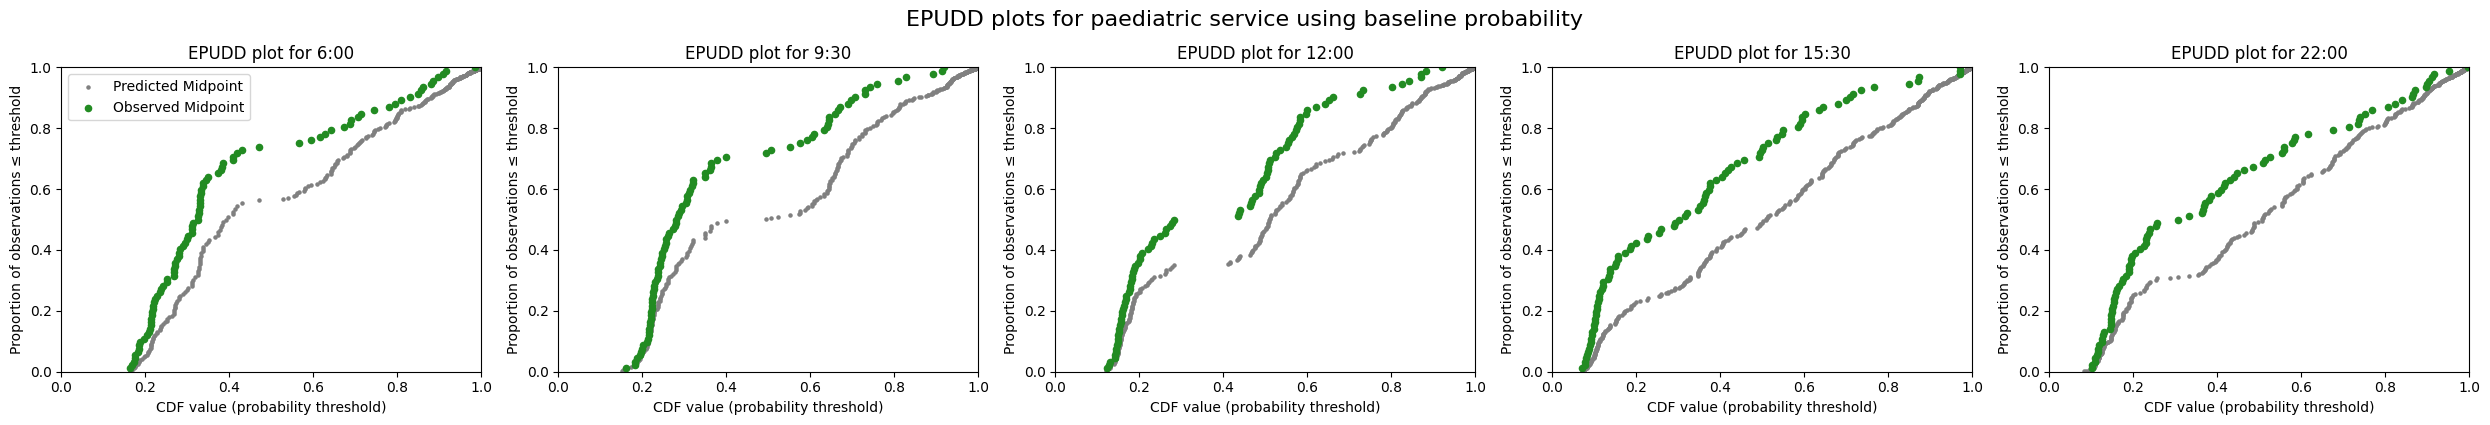

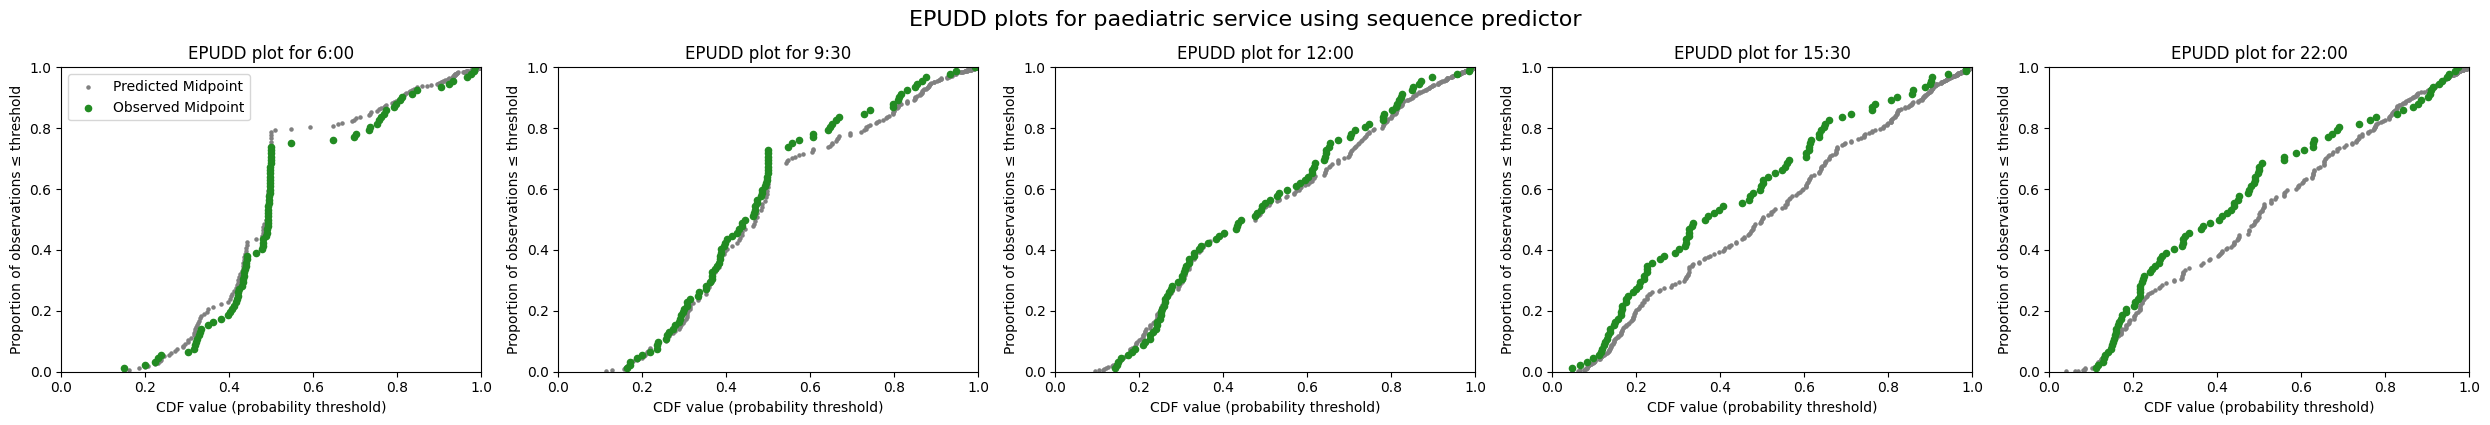

In [9]:
for specialty in specialties:

    specialty_prob_dist_baseline = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all_baseline.items()}
    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}

    print(f'\nEPUDD plots for {specialty} service: baseline vs sequence predictor')

    plot_epudd(ed_visits.prediction_time.unique(), 
        specialty_prob_dist_baseline,
        model_name="admissions",
        suptitle=f"EPUDD plots for {specialty} service using baseline probability")
    
    plot_epudd(ed_visits.prediction_time.unique(), 
        specialty_prob_dist,
        model_name="admissions",
        suptitle=f"EPUDD plots for {specialty} service using sequence predictor")